In [47]:
%load_ext autoreload
%autoreload 2

import time
from tqdm import tqdm

import jax
import jax.numpy as jnp
from flax.training import orbax_utils
import optax
import orbax.checkpoint as ocp

import matplotlib.pyplot as plt
from getdist import MCSamples, plots

from jaxili.model import ConditionalMAF

from gaussian_model.simulator import GaussianPrior, GaussianSimulator, calculate_analytic_posterior, GenerativeModel
from network import MLPCompressor, MAF_MLPCompressor
from loss import loss_nll_npe, loss_nll_nle, loss_mmd_npe, mmd_summary_space

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%matplotlib inline
jax.devices()

[cuda(id=0)]

In [3]:
plt.rcParams.update({
    "axes.labelsize": 20,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["times"],
    "text.latex.preamble": r"\usepackage{amsmath}"
})

In [4]:
master_key = jax.random.PRNGKey(1234)

### Train the network with sufficient and overcomplete network

In [5]:
prior = GaussianPrior()
simulator = GaussianSimulator()

prior_fun = lambda rng_key, num_samples : prior.sample(rng_key, num_samples)
simulator_fun = lambda params, rng_key, num_samples : simulator.sample(params, rng_key, num_samples)
generative_model = GenerativeModel(prior_fun, simulator_fun)

In [44]:
theta, x = generative_model.generate(master_key, 1000)

calculate_analytic_posterior(prior, simulator, x)[0]

Array([[-0.481591  , -0.780136  ],
       [ 0.10555494, -0.3825057 ],
       [ 0.49948007, -0.28683794],
       ...,
       [-0.7832562 ,  0.145636  ],
       [-0.53726566, -0.8888482 ],
       [-0.5865737 ,  0.8350199 ]], dtype=float32)

In [46]:
theta

Array([[-0.02397393, -0.3653231 ],
       [ 1.3926693 , -0.6395825 ],
       [ 0.44630814,  0.8246285 ],
       ...,
       [-0.9946117 ,  0.6118721 ],
       [-1.0248342 , -0.95074135],
       [ 0.3816265 ,  1.1948297 ]], dtype=float32)

In [30]:
mu_0

Array([[0.],
       [0.]], dtype=float32)

In [6]:
#Train the network for the sufficient statistics
dim_param = 2
dim_sim = 2
output_sufficient = 2

mlp_hparams_sufficient = {
    'hidden_size': [128, 128],
    'output_size': output_sufficient
}

nf_hparams_sufficient = {
    'n_in': dim_param,
    'n_cond': output_sufficient,
    'n_layers': 2,
    'layers': [128, 128],
    'activation': jax.nn.relu,
    'use_reverse': True,
    'seed': 42
}

#Create the model
nf_mlp_compressor_sufficient = MAF_MLPCompressor(
    MLPCompressor,
    ConditionalMAF,
    mlp_hparams_sufficient,
    nf_hparams_sufficient
)

key, master_key = jax.random.split(master_key)
params_nf_mlp_sufficient = nf_mlp_compressor_sufficient.init(key, jnp.ones((2,2)), jnp.ones((2,2)))

print(
    f'Number of parameters: {sum(x.size for x in jax.tree_util.tree_leaves(params_nf_mlp_sufficient))}'
)

Number of parameters: 52490


In [7]:
#Define the update function
def update(params, opt_state, x, theta, loss_fn, optimizer):
    loss, grad = jax.value_and_grad(loss_fn)(params, x, theta)
    updates, opt_state = optimizer.update(grad, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state, loss

update_jit = jax.jit(update, static_argnums=(4, 5))

#Define a function to create batches
def create_batches(data, batch_size, rng_key):
    num_examples = data[0].shape[0]
    indices = jax.random.permutation(rng_key, num_examples)
    for start_idx in range(0, num_examples, batch_size):
        end_idx = min(start_idx + batch_size, num_examples)
        batch_indices = indices[start_idx:end_idx]
        yield data[0][batch_indices], data[1][batch_indices]

def is_new_best_model(val_loss, best_model_loss):
    if best_model_loss is None:
        return True
    return val_loss < best_model_loss
        
#Define the training function
def training_loop(params, opt_state, epochs, n_sims, batch_size, loss_fn, generative_model, optimizer, master_key, checkpoint_path=None):

    #Create the checkpoint manager
    if checkpoint_path is not None:
        options = ocp.CheckpointManagerOptions(max_to_keep=1, create=True)
        orbax_checkpointer = ocp.PyTreeCheckpointer()
        checkpoint_manager = ocp.CheckpointManager(
            checkpoint_path, orbax_checkpointer, options
        )
    #Generate the data
    key, master_key = jax.random.split(master_key)
    train_data = generative_model.generate(key, n_sims)
    key, master_key = jax.random.split(master_key)
    val_data = generative_model.generate(key, n_sims)

    #Perform the training
    train_loss_tracker = []
    val_loss_tracker = []

    pbar = tqdm(range(1, epochs+1), desc="Epochs")
    best_model_loss = None

    start_time = time.time()
    for epoch in pbar:
        key, master_key = jax.random.split(master_key)
        train_loss = 0
        num_train_steps = 0
        for batch in create_batches(train_data, batch_size, key):
            theta, x = batch
            params, opt_state, loss = update_jit(params, opt_state, x, theta, loss_fn, optimizer)
            train_loss += loss
            num_train_steps += 1
        train_loss /= num_train_steps
        train_loss_tracker.append(train_loss)

        #Compute a validation loss
        val_loss = loss_fn(params, val_data[1], val_data[0])
        val_loss_tracker.append(val_loss)

        if is_new_best_model(val_loss, best_model_loss):
            best_model_loss = val_loss
            best_epoch = epoch

            if checkpoint_path is not None:
                save_args = orbax_utils.save_args_from_target(params)
                checkpoint_manager.save(epoch, params, save_kwargs={'save_args' :save_args})
            

        pbar.set_description(f"Epochs. Train loss: {train_loss:.2f}/ Val loss: {val_loss:.2f}/ Best val loss: {best_model_loss:.2f}")
    end_time = time.time()
    print(f"Training done. Time taken: {end_time - start_time:.2f} s")
    print(f"Best loss: {best_model_loss}, best epoch: {best_epoch}")

    if checkpoint_path is not None:
        print("Loading best model...")
        step = checkpoint_manager.latest_step()
        params = checkpoint_manager.restore(step)
        print("Best model loaded...")

    return params, opt_state, loss, train_loss_tracker, val_loss_tracker

In [8]:
#Initialize the optimizer
checkpoint_path = "/home/sacha/Documents/Research project/SBI_model_misspecification/gaussian_model/checkpoints"
epochs = 100
n_sims = 10_000
batch_size = 128
learning_rate = 7e-4
warmup  = 0.1
lr_scheduler = optax.warmup_cosine_decay_schedule(
    init_value=1e-4,
    peak_value=learning_rate,
    end_value=0.01*learning_rate,
    warmup_steps=warmup,
    decay_steps = int(epochs*n_sims * 0.9)
)
optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adam(learning_rate=lr_scheduler)
)

opt_state = optimizer.init(params_nf_mlp_sufficient)

In [9]:
#Define functions for the training
compress = lambda params, x : nf_mlp_compressor_sufficient.apply(params, x, method="compress")
nf = lambda params, theta, z : nf_mlp_compressor_sufficient.apply(params, theta, z, method="log_prob_from_compressed")
loss_fn = lambda params, x, theta : loss_mmd_npe(compress, nf, params, (theta, x))

#Training loop
params_nf_mlp_sufficient, opt_state, loss, train_loss_tracker, val_loss_tracker = training_loop(
    params_nf_mlp_sufficient,
    opt_state,
    epochs=epochs,
    n_sims=n_sims,
    batch_size=batch_size,
    loss_fn=loss_fn,
    generative_model=generative_model,
    optimizer=optimizer,
    master_key=master_key,
    checkpoint_path=None
)

Epochs. Train loss: 2.27/ Val loss: 2.16/ Best val loss: 2.15: 100%|██████████| 100/100 [00:54<00:00,  1.85it/s]

Training done. Time taken: 54.07 s
Best loss: 2.1509859561920166, best epoch: 14


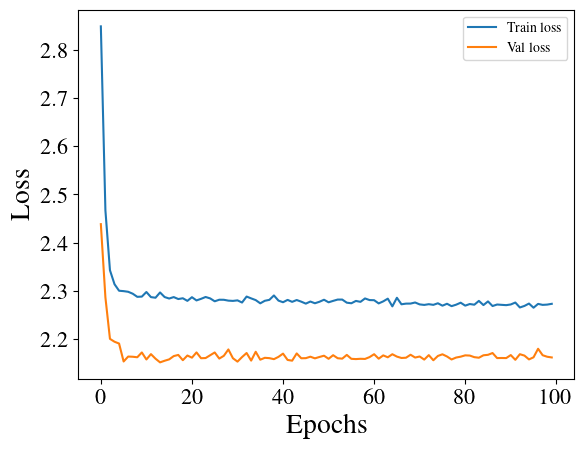

In [10]:
plt.figure()

plt.plot(train_loss_tracker, label="Train loss")
plt.plot(val_loss_tracker, label="Val loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [11]:
theta_val, x_val = generative_model.generate(jax.random.PRNGKey(0), int(10_000/3))

z_val = compress(params_nf_mlp_sufficient, x_val)
key, master_key = jax.random.split(master_key)
mmd = mmd_summary_space(z_val, jax.random.PRNGKey(0))
log_prob = nf(params_nf_mlp_sufficient, theta_val, z_val)

print(f"MMD: {mmd}")
print(f"Negative Log_Likelihood: {-jnp.mean(log_prob)}")
print(f"Loss: {-jnp.mean(log_prob) + mmd}")

MMD: 0.008150100708007812
Negative Log_Likelihood: 2.1445071697235107
Loss: 2.1526572704315186


Removed no burn in


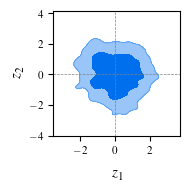

In [12]:
samples_z = MCSamples(
    samples=z_val,
    names=['z1', 'z2'],
    labels=['z_1', 'z_2']
)

g = plots.get_subplot_plotter()
g.plot_2d(samples_z, ['z1', 'z2'], filled=True)
g.add_x_marker(0)
g.add_y_marker(0)

plt.show()

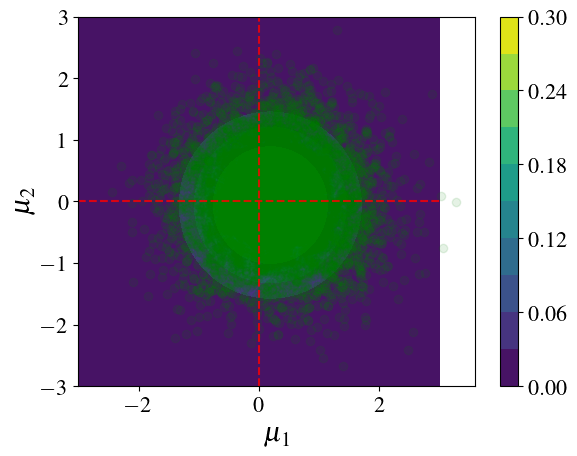

In [13]:
def posterior_distribution(mu, x):
    """
    Posterior density function of the well-specified model.
    mu: parameters
    x: observed data
    """
    mu = mu.squeeze()
    x = x.squeeze()
    normalization = 1/jnp.pi*jnp.exp(-0.25*(jnp.dot(x, x)))
    return normalization * jnp.exp(-0.5*(jnp.dot(mu, mu)+jnp.dot(x-mu, x-mu)))

fiducial_params = jnp.array([0.0, 0.0])
key, master_key = jax.random.split(master_key)
observation = simulator(fiducial_params, key, 1)

plt.figure()

mu_1 = jnp.linspace(-3, 3, 100)
mu_1, mu_2 = jnp.meshgrid(mu_1, mu_1)

density = jax.vmap(posterior_distribution, in_axes=[0, None])(jnp.stack([mu_1, mu_2], axis=-1).reshape(-1, 2), observation)
density = density.reshape(100, 100)

key, master_key = jax.random.split(master_key)

samples = nf_mlp_compressor_sufficient.apply(params_nf_mlp_sufficient, x=observation, n_samples=10000, rng_key=key, method="sample")

plt.contourf(mu_1, mu_2, density, levels=10)
plt.colorbar()

plt.scatter(samples[:, 0], samples[:, 1], alpha=0.1, color='g', label="Samples")

plt.hlines(fiducial_params[1], -3, 3, color='r', label="True $\mu_2$", ls='--', alpha=0.8)
plt.vlines(fiducial_params[0], -3, 3, color='r', label="True $\mu_1$", ls='--', alpha=0.8)

plt.xlabel(r"$\mu_1$")
plt.ylabel(r"$\mu_2$")

plt.show()

In [14]:
#Train the network for the overcomplete statistics
dim_param = 2
dim_sim = 2
output_overcomplete = 4

mlp_hparams_overcomplete = {
    'hidden_size': [128, 128],
    'output_size': output_overcomplete
}

nf_hparams_overcomplete = {
    'n_in': dim_param,
    'n_cond': output_overcomplete,
    'n_layers': 2,
    'layers': [128, 128],
    'activation': jax.nn.relu,
    'use_reverse': True,
    'seed': 42
}

#Create the model
nf_mlp_compressor_overcomplete = MAF_MLPCompressor(
    MLPCompressor,
    ConditionalMAF,
    mlp_hparams_overcomplete,
    nf_hparams_overcomplete
)

key, master_key = jax.random.split(master_key)
params_nf_mlp_overcomplete = nf_mlp_compressor_overcomplete.init(key, jnp.ones((1,2)), jnp.ones((1,2)))

print(
    f'Number of parameters: {sum(x.size for x in jax.tree_util.tree_leaves(params_nf_mlp_overcomplete))}'
)

Number of parameters: 53260


In [15]:
#Initialize the optimizer
checkpoint_path = "/home/sacha/Documents/Research project/SBI_model_misspecification/gaussian_model/checkpoints"
epochs = 100
n_sims = 10_000
batch_size = 128
learning_rate = 7e-4
warmup  = 0.1
lr_scheduler = optax.warmup_cosine_decay_schedule(
    init_value=1e-4,
    peak_value=learning_rate,
    end_value=0.01*learning_rate,
    warmup_steps=warmup,
    decay_steps = int(epochs*n_sims * 0.9)
)
optimizer = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adam(learning_rate=lr_scheduler)
)

opt_state = optimizer.init(params_nf_mlp_overcomplete)

In [16]:
#Define functions for the training
compress = lambda params, x : nf_mlp_compressor_overcomplete.apply(params, x, method="compress")
nf = lambda params, theta, z : nf_mlp_compressor_overcomplete.apply(params, theta, z, method="log_prob_from_compressed")
loss_fn = lambda params, x, theta : loss_mmd_npe(compress, nf, params, (theta, x))

#Training loop
params_nf_mlp_overcomplete, opt_state, loss, train_loss_tracker, val_loss_tracker = training_loop(
    params_nf_mlp_overcomplete,
    opt_state,
    epochs=epochs,
    n_sims=n_sims,
    batch_size=batch_size,
    loss_fn=loss_fn,
    generative_model=generative_model,
    optimizer=optimizer,
    master_key=master_key,
    checkpoint_path=None
)

Epochs. Train loss: 2.28/ Val loss: 2.20/ Best val loss: 2.18: 100%|██████████| 100/100 [00:52<00:00,  1.92it/s]

Training done. Time taken: 52.12 s
Best loss: 2.181363821029663, best epoch: 91


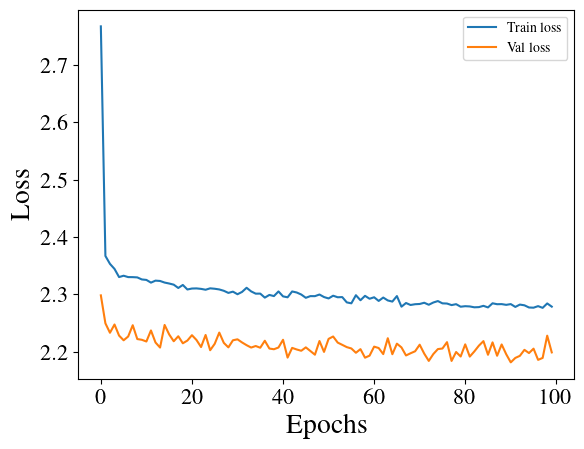

In [17]:
plt.figure()

plt.plot(train_loss_tracker, label="Train loss")
plt.plot(val_loss_tracker, label="Val loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [18]:
theta_val, x_val = generative_model.generate(jax.random.PRNGKey(0), int(10_000/3))

z_val = compress(params_nf_mlp_overcomplete, x_val)
key, master_key = jax.random.split(master_key)
mmd = mmd_summary_space(z_val, jax.random.PRNGKey(0))
log_prob = nf(params_nf_mlp_overcomplete, theta_val, z_val)

print(f"MMD: {mmd}")
print(f"Negative Log_Likelihood: {-jnp.mean(log_prob)}")
print(f"Loss: {-jnp.mean(log_prob) + mmd}")

MMD: 0.05462455749511719
Negative Log_Likelihood: 2.13802433013916
Loss: 2.1926488876342773


Removed no burn in


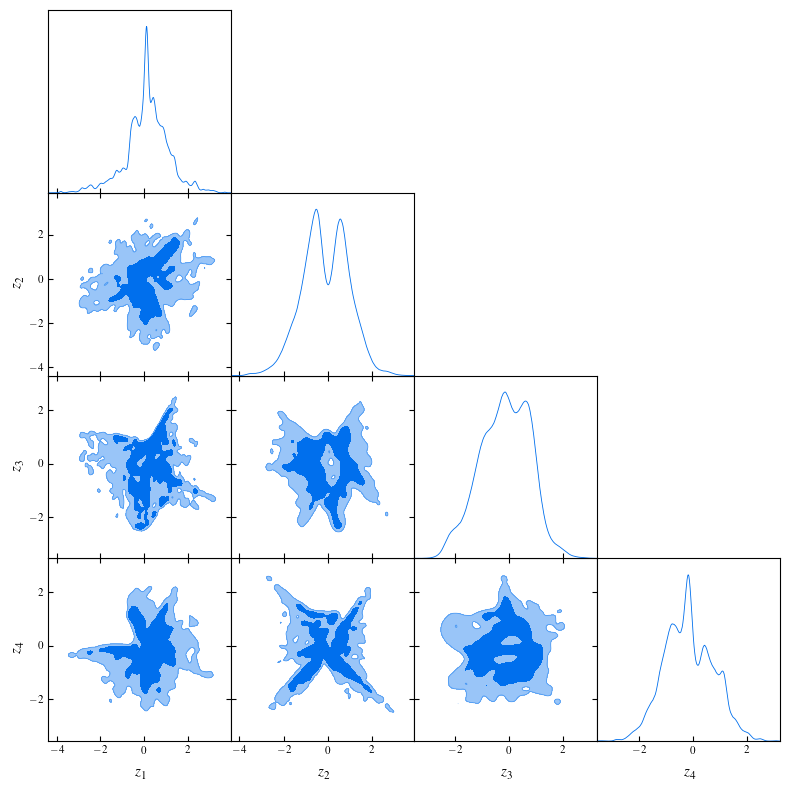

In [19]:
samples_z = MCSamples(
    samples=z_val,
    names=['z1', 'z2', 'z3', 'z4'],
    labels=['z_1', 'z_2', 'z_3', 'z_4']
)

g = plots.get_subplot_plotter()
g.triangle_plot(samples_z, filled=True)

plt.show()

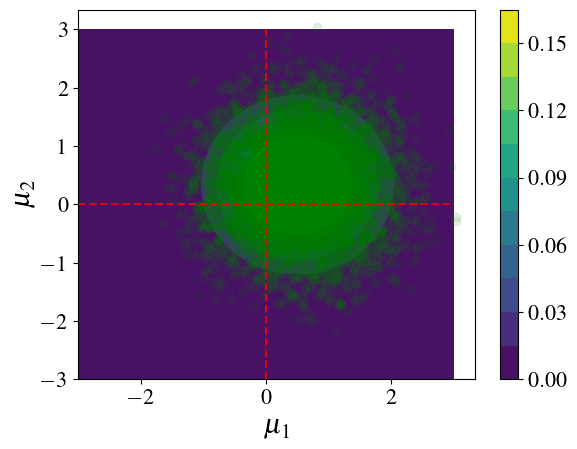

In [20]:
fiducial_params = jnp.array([0.0, 0.0])
key, master_key = jax.random.split(master_key)
observation = simulator(fiducial_params, key, 1)

plt.figure()

mu_1 = jnp.linspace(-3, 3, 100)
mu_1, mu_2 = jnp.meshgrid(mu_1, mu_1)

density = jax.vmap(posterior_distribution, in_axes=[0, None])(jnp.stack([mu_1, mu_2], axis=-1).reshape(-1, 2), observation)
density = density.reshape(100, 100)

key, master_key = jax.random.split(master_key)

samples = nf_mlp_compressor_overcomplete.apply(params_nf_mlp_overcomplete, x=observation, n_samples=10000, rng_key=key, method="sample")

plt.contourf(mu_1, mu_2, density, levels=10)
plt.colorbar()

plt.scatter(samples[:, 0], samples[:, 1], alpha=0.1, color='g', label="Samples")

plt.hlines(fiducial_params[1], -3, 3, color='r', label="True $\mu_2$", ls='--', alpha=0.8)
plt.vlines(fiducial_params[0], -3, 3, color='r', label="True $\mu_1$", ls='--', alpha=0.8)

plt.xlabel(r"$\mu_1$")
plt.ylabel(r"$\mu_2$")

plt.show()

### Expected vs true coverage